# Práctica 2: Visualización de datos

## Estudio del sistema ferroviario de media y larga en la península ibérica

Los datos se han obtenido de la dirección url: https://data.renfe.com/dataset/horarios-de-alta-velocidad-larga-distancia-y-media-distancia .
Se ha de tener en cuenta que, a pesar de ser datos oficiales ofrecidos por la propia Renfe, estos no muestran datos fiables, por lo que el uso de este set de datos se da con fines puramente académicos

In [200]:
import pandas as pd
import matplotlib.pyplot as plt

calendar = pd.read_csv('calendar.txt')
calendar_dates = pd.read_csv('calendar_dates.txt')
stops = pd.read_csv('stops.txt')
stop_times = pd.read_csv('stop_times.txt')
trips = pd.read_csv('trips.txt') 
routes = pd.read_csv('routes.txt')


In [201]:
total_amount = routes.shape[0]
total_amount

599

Renfe mantiene un total de 599 líneas.

In [202]:
route_count = routes.groupby(['route_short_name']).size().reset_index(name='counts')

colors = {'Intercity':'white', 'ALVIA':'gray', 'TORRE ORO':'gold', 'EUROMED':'blue', 'AVE':'MediumVioletRed',
         'AVLO':'green', 'AVANT':'orange', 'MD':'red', 'REGIONAL': 'crimson', 'REG.EXP.': 'purple', 'RODALIES':'salmon'  }
route_count['color'] = route_count['route_short_name'].apply(lambda x: colors[x])

route_count = route_count.sample(frac=1).reset_index(drop=True)



### Servicios de Renfe 

Estudiamos la distribución de los servicios,a tenor de la cantidad de rutas que ofrece cada uno.

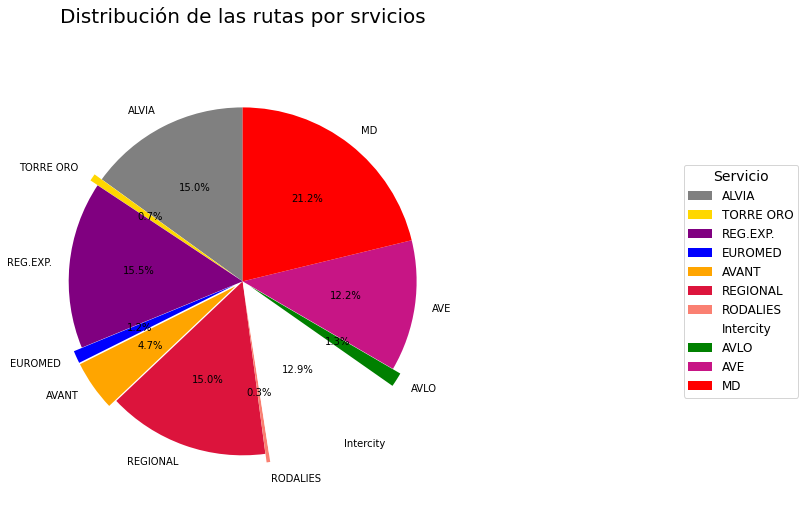

In [204]:
fig, ax = plt.subplots(figsize=(8, 8)) # make the plot bigger
explode = [0.05 if val < route_count['counts'].mean() else 0 for val in route_count['counts']]
ax.pie(route_count['counts'], labels=route_count['route_short_name'], colors=route_count['color'], 
       autopct='%1.1f%%', startangle=90, textprops={'color':'black'}, explode=explode)

ax.set_title("Distribución de las rutas por srvicios", fontsize=20, color='black', y=1.08)

legend = ax.legend(rxoute_count['route_short_name'], title="Servicio", 
                  bbox_to_anchor=(1.5, 0.5), loc="center left", fontsize=12)
legend.get_title().set_fontsize(14)

plt.show()

In [207]:
trips.rename(columns = {'wheelchair_accessible                                                                                                                                                                                                                                                ':'wheelchair_accesible'}, inplace = True)

### 2. Accesibilidad 

Nos preguntamos por el estado de la accesibilidad para sillas de ruedas en el sistema ferroviario. En el siguiente gráfico observamos la distribución por servicio.

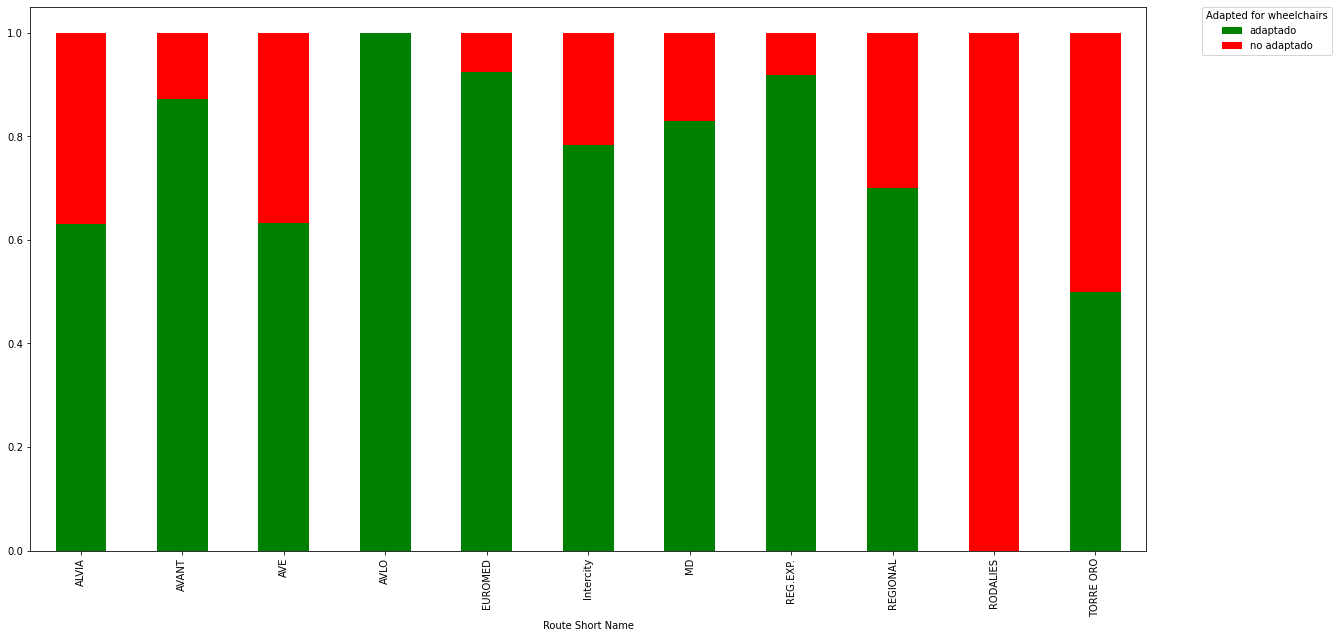

In [208]:
merged_df = pd.merge(trips, routes, left_on='route_id', right_on='route_id')

grouped_df = merged_df.groupby(['route_short_name', 'wheelchair_accesible']).size().reset_index(name='counts')

grouped_df['wheelchair_accesible'] = grouped_df['wheelchair_accesible'].replace({1: 'adaptado', 2: 'no adaptado'})

grouped_df = grouped_df.groupby(['route_short_name']).apply(lambda x: x.assign(counts = x.counts/x.counts.sum()))

fig, ax = plt.subplots(figsize=(20,10))

pivot_df = grouped_df.pivot(index='route_short_name', columns='wheelchair_accesible', values='counts')
pivot_df.plot(kind='bar', stacked=True, color=['green', 'red'],ax=ax)

plt.xlabel("Route Short Name")
plt.legend(title="Adapted for wheelchairs", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Observamos en el mapa la localización de las paradas con accesibilidad.

![My Image](accesibilidad.png)

Vemos que, a pesar de que muchos de los servicios ofrecen accesibilidad, la mayor parte de las paradas aún carecen de este tipo de ayuda al consumidor. También podemos observar que muchas de las paradas con acceso a sillas de ruedas se encuentran en centros poblacionales como capitales de provincia. Esto, a pesar de tener lógica, hace que el servicio público no sea una buena solución para personas con discapacidad en entornos rurales.

Vemos que la infraestructura de alta velocidad es más simple que el conjunto de la infraestructura total

In [209]:
merged_1 = pd.merge(stop_times, stops, on='stop_id')

merged_2 = pd.merge(merged_1, trips, on='trip_id')

merged_df = pd.merge(merged_2, routes, on='route_id')

In [211]:
merged_df = merged_df.drop(columns=['stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled                                                                                                                                                                                                                                         ', 'stop_code', 'shape_id', 'agency_id', 'route_long_name', 'route_type', 'route_url', 'route_color', 'route_text_color                                                                                                                                                                                                                                              ', 'trip_headsign', 'direction_id', 'block_id', 'stop_desc', 'zone_id', 'route_desc', 'stop_url', 'location_type', 'parent_station'])

In [212]:
date = merged_df["trip_id"].str[-10:]

merged_df["arrival_date"] = date + " " + merged_df["arrival_time"]
merged_df["departure_date"] = date + " " + merged_df["departure_time"]

merged_df["arrival_date"] = pd.to_datetime(merged_df["arrival_date"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
merged_df["departure_date"] = pd.to_datetime(merged_df["departure_date"], format="%Y-%m-%d %H:%M:%S", errors='coerce')

invalid_rows = pd.isnull(merged_df["arrival_date"]) | pd.isnull(merged_df["departure_date"])

merged_df.loc[invalid_rows, "arrival_date"] = merged_df.loc[invalid_rows, "arrival_date"] + pd.Timedelta(days=1) - pd.Timedelta(hours=24)
merged_df.loc[invalid_rows, "departure_date"] = merged_df.loc[invalid_rows, "departure_date"] + pd.Timedelta(days=1) - pd.Timedelta(hours=24)

In [213]:
merged_df.to_csv('merged_data_2.csv', index=False)

### Distribución de los servicios en el mapa

![My Image](distribucion_servicios.png)

Para comprender mejor la complejidad de los servicios ferroviarios, estudiaremos por separado los servicios de alta velocidad de los demás.

### Alta velocidad

![My Image](alta_velocidad.png)

In [214]:
merged_df["alta_velocidad"] = merged_df["route_short_name"].map({"AVE":1, "AVLO":1}).fillna(0)

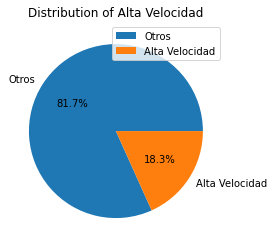

In [215]:
merged_df["alta_velocidad"].replace({1: "Alta Velocidad", 0: "Otros"}, inplace=True)

counts = merged_df["alta_velocidad"].value_counts()

plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title("Distribution of Alta Velocidad")
plt.legend()
plt.show()

Vemos que, en efecto, los servicios de alta velocidad representan menos de una quinta parte de los servicios otorgados por Renfe.

Observamos a continucación los movimientos de los trenes a través del tiempo durante la semana de navidad

In [194]:
from IPython.display import Video

Video("alta_velocidad.mp4")

### Otros servicios

Los servicios de media y larga distnacia que no usan infrestructura de alta velocidad suponen más del 80% del total.

![My Image](media_distancia.png)

Aquí podemos ver, además, como se distribuyen dichos servicios en la península.

In [197]:
Video("otros_servicios.mp4")

En este clip podemos apreciar la complejidad del sistema durante la semana de navidad del 2022.